In [83]:
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import msprime  # >= 0.5
import numpy as np
from math import sqrt
from scipy.stats import norm
import scipy
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import seaborn as sns
import tskit
import pandas as pd
import math
import multiprocessing
import matplotlib.pyplot as plt
from IPython.display import SVG

In [87]:
no_samples = 20
tree_sequence = msprime.simulate(
     sample_size=no_samples, Ne=1e4, length=5e3, recombination_rate=2e-8,
     mutation_rate=2e-8, random_seed=10)

tree = tree_sequence.first()

#SVG(tree.draw())
print(tree.draw(format="unicode"))

                                     45          
                             ┏━━━━━━━━┻━━━━━━━━┓ 
                            44                 ┃ 
                  ┏━━━━━━━━━━┻━━━━━━━━━━┓      ┃ 
                 41                     ┃      ┃ 
   ┏━━━━━━━━━━━━━━┻━━━━━━━━━━━━━┓       ┃      ┃ 
  38                            ┃       ┃      ┃ 
┏━━┻━━┓                         ┃       ┃      ┃ 
┃     ┃                        36       ┃      ┃ 
┃     ┃                      ┏━━┻━┓     ┃      ┃ 
┃     ┃                      ┃    ┃    35      ┃ 
┃     ┃                      ┃    ┃   ┏━┻━┓    ┃ 
┃    34                      ┃    ┃   ┃   ┃    ┃ 
┃ ┏━━━┻━━━━┓                 ┃    ┃   ┃   ┃    ┃ 
┃ ┃        ┃                 ┃    ┃   ┃  33    ┃ 
┃ ┃        ┃                 ┃    ┃   ┃  ┏┻━┓  ┃ 
┃ ┃       32                 ┃    ┃   ┃  ┃  ┃  ┃ 
┃ ┃ ┏━━━━━━┻━━━━━━┓          ┃    ┃   ┃  ┃  ┃  ┃ 
┃ ┃ ┃            31          ┃    ┃   ┃  ┃  ┃  ┃ 
┃ ┃ ┃        ┏━━━━┻━━━┓      ┃    ┃   ┃  ┃  ┃  ┃ 


In [85]:

def fx(x_coord): 
    return -x_coord
def fy(y_coord):
    return -y_coord
def orderOfMagnitude(number):
    if (number % 10 == 0): 
        return math.ceil(math.log(number, 10))
    else: 
        return math.floor(math.log(number, 10))

def brownian(start_pt, time, delta):
    x0 = start_pt
    r = norm.rvs(size=(2,), scale=delta*sqrt(time))
    return np.array(x0 + r)

    
def returnOUcoords(start_pt, time,drag, diff_const):
    sigma = time  # Standard deviation.
    mu = np.array(0)  # Mean.
    theta = drag
    division_factor = 10**(orderOfMagnitude(time) +2)
    D = diff_const #diffusion constant
    dt = time/division_factor  # Time step.
    T = time  # Total time.
    n = int(T / dt)  # Number of time steps.
    t = np.linspace(0., T, n)  # Vector of times.
    sigma_bis = np.sqrt(2 * D)
    sqrtdt = np.sqrt(dt)
    v = np.zeros((n,2))
    x = np.zeros((n,2))
    x[0] = start_pt
    v[0] = np.array([0,0])
    for i in range(n - 1):
        v[i + 1,0] = v[i,0] + theta*dt*(-(v[i,0] - mu)) + sigma_bis * sqrtdt * np.random.randn()
        v[i + 1,1] = v[i,1] + theta*dt*(-(v[i,1] - mu)) + sigma_bis * sqrtdt * np.random.randn()
        x[i+1, 0] = x[i, 0] + v[i, 0]*dt
        x[i+1, 1] = x[i, 1] + v[i,1]*dt
    return x[n-1]
def returnForceFieldcoords(start_pt, time,drag, diff_const):
    sigma = time  # Standard deviation.
    mu = np.array(0)  # Mean.
    theta = drag #drag coefficient
    D = diff_const #diffusion constant
    dt = 1 # Time step.
    T = time  # Total time.
    n = int(T / dt)  # Number of time steps.
    t = np.linspace(0., T, n)  # Vector of times.
    sigma_bis = np.sqrt(2 * D)
    sqrtdt = np.sqrt(dt)
    v = np.zeros((n,2))
    x = np.zeros((n,2))
    x[0] = start_pt
    v[0] = np.array([0,0])
    for i in range(n - 1):
        v[i + 1,0] = v[i,0] + fx(x[i,0]) + theta*dt*(-(v[i,0])) + sigma_bis * sqrtdt * np.random.randn()
        v[i + 1,1] = v[i,1] + fy(x[i,1]) + theta*dt*(-(v[i,1])) + sigma_bis * sqrtdt * np.random.randn()
        x[i+1, 0] = x[i, 0] + v[i,0]*dt
        x[i+1, 1] = x[i, 1] + v[i,1]*dt
    return x[n-1]
y = returnForceFieldcoords([178,-50], 100, 1, 1)
print(y)


[-160.85866425   59.74660159]


1113.4984748080196
71175.40082508339


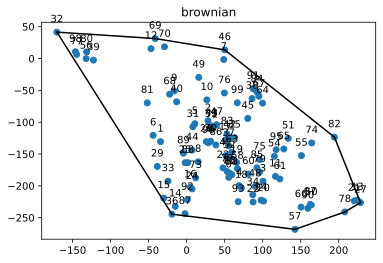

194.44650560486627
2007.7356230952655


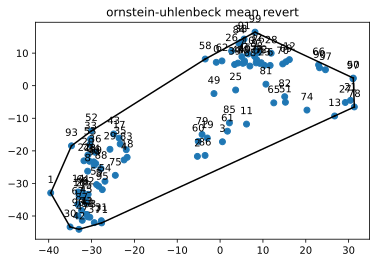

50.17043045601175
172.87855047428377


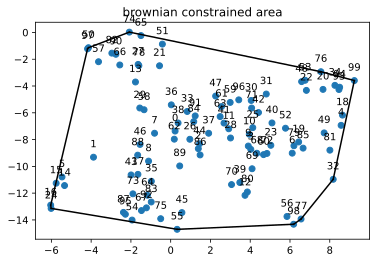

235.53541067357384
3552.4848911731524


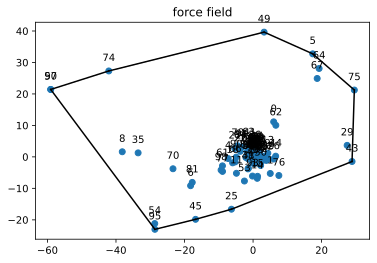

In [86]:
DIFF_CONST = 0.01
DRAG = 1
def getCoordsFromPhylogeny(tree, no_samples): 
    list_of_paths = []
    for u in range(no_samples):
        path = []
        while u != tskit.NULL:
            path.insert(0, u)
            u = tree.parent(u)
        list_of_paths.append(path)
    list_of_times = []
    for l in list_of_paths: 
        times = []
        for j in l[1:]: 
            times.append(tree.branch_length(j))
        list_of_times.append(times)
    largest_node = list_of_paths[0][0]
    coords = np.zeros((largest_node+1, 2))
    for path, time in zip(list_of_paths, list_of_times): 
        for i in range(len(path) -1): 
            if(np.array_equal(coords[path[i+1],:], np.zeros((2,)))):
                coords[path[i+1], :] = brownian(coords[path[i], :], time[i], 1)
    return coords[:no_samples, :]
#Assume tumor is constrained to a circle of area A
def getCoordsFromPhylogenyFixedArea(tree, no_samples, constrain_area): 
    Area_tumor = math.inf
    scaling_factor = 1
    while(Area_tumor > constrain_area): 
        list_of_paths = []
        for u in range(no_samples):
            path = []
            while u != tskit.NULL:
                path.insert(0, u)
                u = tree.parent(u)
            list_of_paths.append(path)
        list_of_times = []
        for l in list_of_paths: 
            times = []
            for j in l[1:]: 
                times.append(tree.branch_length(j)/scaling_factor)
            list_of_times.append(times)
        largest_node = list_of_paths[0][0]
        coords = np.zeros((largest_node+1, 2))
        for path, time in zip(list_of_paths, list_of_times): 
            for i in range(len(path) -1): 
                if(np.array_equal(coords[path[i+1],:], np.zeros((2,)))):
                    coords[path[i+1], :] = brownian(coords[path[i], :], time[i], 1)
        final_samples = coords[:no_samples, :]
        hull = ConvexHull(final_samples)
        Area_tumor = hull.volume
        scaling_factor +=1 
    return final_samples
def getCoordsOUProcess(tree, no_samples): 
    list_of_paths = []
    for u in range(no_samples):
        path = []
        while u != tskit.NULL:
            path.insert(0, u)
            u = tree.parent(u)
        list_of_paths.append(path)
    list_of_times = []
    for l in list_of_paths: 
        times = []
        for j in l[1:]: 
            times.append(tree.branch_length(j))
        list_of_times.append(times)
    largest_node = list_of_paths[0][0]
    coords = np.zeros((largest_node+1, 2))
    
    for path, time in zip(list_of_paths, list_of_times): 
        for i in range(len(path) -1): 
            if(np.array_equal(coords[path[i+1],:], np.zeros((2,)))):
                coords[path[i+1], :] = returnOUcoords(coords[path[i], :], time[i],DRAG, DIFF_CONST)
    return coords[:no_samples, :]
def getCoordsForceFieldProcess(tree, no_samples): 
    list_of_paths = []
    for u in range(no_samples):
        path = []
        while u != tskit.NULL:
            path.insert(0, u)
            u = tree.parent(u)
        list_of_paths.append(path)
    list_of_times = []
    for l in list_of_paths: 
        times = []
        for j in l[1:]: 
            times.append(tree.branch_length(j))
        list_of_times.append(times)
    largest_node = list_of_paths[0][0]
    coords = np.zeros((largest_node+1, 2))
    
    for path, time in zip(list_of_paths, list_of_times): 
        for i in range(len(path) -1): 
            if(np.array_equal(coords[path[i+1],:], np.zeros((2,)))):
                coords[path[i+1], :] = returnForceFieldcoords(coords[path[i], :], time[i],DRAG, DIFF_CONST)
    return coords[:no_samples, :]
b = getCoordsFromPhylogeny(tree, no_samples)
c = getCoordsOUProcess(tree, no_samples)
s =  getCoordsFromPhylogenyFixedArea(tree, no_samples, 200)
f = getCoordsForceFieldProcess(tree, no_samples)
list = [b, c, s, f]
count = 0
for i in list: 
    hull = ConvexHull(i)
    print(hull.area)
    print(hull.volume)
    plt.scatter(i[:,0], i[:,1])
    tum = range(no_samples)
    for x, y, z in zip(i[:,0], i[:,1], tum):

        plt.annotate(z, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center')
    for simplex in hull.simplices:
        plt.plot(i[simplex, 0], i[simplex, 1], 'k-')
    if (count == 0): 
        plt.title('brownian')
    elif (count == 1): 
        plt.title('ornstein-uhlenbeck mean revert')
    elif(count == 2): 
        plt.title('brownian constrained area')
    else: 
        plt.title('force field')
    plt.show()
    count += 1
    

In [7]:
list_of_paths = []
for u in range(6):
    path = []
    while u != tskit.NULL:
        path.insert(0, u)
        print("node {}: time = {}".format(u, tree.time(u)))
        u = tree.parent(u)
    list_of_paths.append(path)
print(list_of_paths)
#create lists from root to leaf
#create coords nx 2 null array
#loop through lists and do a brownian if it doesnt exist. 

node 0: time = 0.0
node 38: time = 4432.7215812228005
node 41: time = 9077.212241176183
node 44: time = 17054.35603625601
node 45: time = 19560.868641320307
node 1: time = 0.0
node 26: time = 1028.7384172534128
node 45: time = 19560.868641320307
node 2: time = 0.0
node 34: time = 2491.652282796645
node 38: time = 4432.7215812228005
node 41: time = 9077.212241176183
node 44: time = 17054.35603625601
node 45: time = 19560.868641320307
node 3: time = 0.0
node 21: time = 105.80502148105452
node 27: time = 1483.1944483045788
node 36: time = 2791.571216104694
node 41: time = 9077.212241176183
node 44: time = 17054.35603625601
node 45: time = 19560.868641320307
node 4: time = 0.0
node 21: time = 105.80502148105452
node 27: time = 1483.1944483045788
node 36: time = 2791.571216104694
node 41: time = 9077.212241176183
node 44: time = 17054.35603625601
node 45: time = 19560.868641320307
node 5: time = 0.0
node 28: time = 1512.4038558924285
node 35: time = 2512.9996549303714
node 44: time = 17054.

[[2506.5126050642975, 7977.143795079826, 4644.490659953382, 4432.7215812228005], [18532.130224066896, 1028.7384172534128], [2506.5126050642975, 7977.143795079826, 4644.490659953382, 1941.0692984261555, 2491.652282796645], [2506.5126050642975, 7977.143795079826, 6285.641025071489, 1308.3767678001152, 1377.3894268235242, 105.80502148105452], [2506.5126050642975, 7977.143795079826, 6285.641025071489, 1308.3767678001152, 1377.3894268235242, 105.80502148105452], [2506.5126050642975, 14541.356381325637, 1000.5957990379429, 1512.4038558924285]]
[[-310.28380495 -197.22109297]
 [-254.33163128  157.34691423]
 [-159.90108943 -129.15179279]
 [ -23.17980616  -61.24282118]
 [ -19.45251663  -63.84720595]
 [ -92.78190727 -113.10137271]
 [   0.            0.        ]
 [   0.            0.        ]
 [   0.            0.        ]
 [   0.            0.        ]
 [   0.            0.        ]
 [   0.            0.        ]
 [   0.            0.        ]
 [   0.            0.        ]
 [   0.            0. 

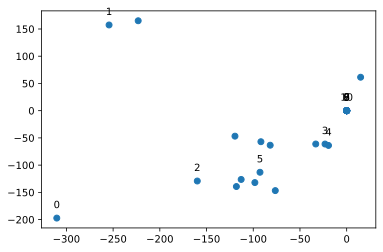

In [8]:
list_of_times = []
for l in list_of_paths: 
    times = []
    for j in l[1:]: 
        times.append(tree.branch_length(j))
    list_of_times.append(times)
print(list_of_times)
def simulateTree(times, paths): 
    largest_node = paths[0][0]
    coords = np.zeros((largest_node+1, 2))
    for path, time in zip(paths, times): 
        for i in range(len(path) -1): 
            if(np.array_equal(coords[path[i+1],:], np.zeros((2,)))):
                coords[path[i+1], :] = brownian(coords[path[i], :], time[i], 1)
    return coords
c = simulateTree(list_of_times, list_of_paths)
print(c)

plt.scatter(c[:,0], c[:,1])
tum = range(11)
for x, y, z in zip(c[:,0], c[:,1], tum):

    plt.annotate(z, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')

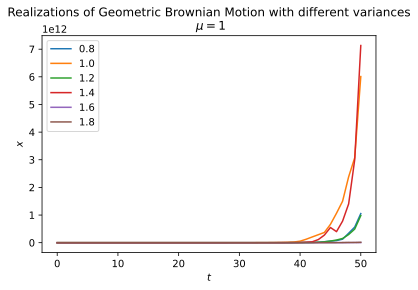

In [9]:
#Geometric brownian motion test

mu = 5
n = 50
dt = 0.1
x0 = 100
np.random.seed(1)

sigma = np.arange(0.8, 2, 0.2)

x = np.exp(
    (mu - sigma ** 2 / 2) * dt
    + sigma * np.random.normal(0, np.sqrt(dt), size=(len(sigma), n)).T
)
x = np.vstack([np.ones(len(sigma)), x])
x = x0 * x.cumprod(axis=0)

plt.plot(x)
plt.legend(np.round(sigma, 2))
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.title(
    "Realizations of Geometric Brownian Motion with different variances\n $\mu=1$"
)
plt.show()

In [10]:
# this is mutation on population level
# can only know which individual carry the mutation
# but cannot know where the mutation in the genomo
for variant in tree_sequence.variants():
    print(
         variant.site.id, variant.site.position,
        variant.alleles, variant.genotypes, sep="\t")

0	2432.768327416852	('0', '1')	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
1	2577.6939414924095	('0', '1')	[1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
2	2844.682702049562	('0', '1')	[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
3	4784.266628557816	('0', '1')	[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]


In [11]:
variant

{'site': {'id': 3, 'position': 4784.266628557816, 'ancestral_state': '0', 'mutations': [{'id': 3, 'site': 3, 'node': 8, 'time': nan, 'derived_state': '1', 'parent': -1, 'metadata': b''}], 'metadata': b''}, 'alleles': ('0', '1'), 'has_missing_data': False, 'num_alleles': 2, 'genotypes': array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int8), 'position': 4784.266628557816, 'index': 3}

In [12]:
tree_sequence.genotype_matrix()

array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int8)

In [13]:
tree.branch_length(3)

105.80502148105452

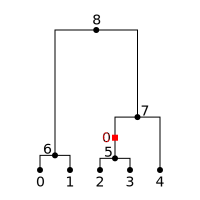

In [14]:
ts = msprime.simulate(5,mutation_rate=0.1, length=4)
tree = ts.first()
SVG(tree.draw())

In [15]:
for variant in ts.variants():
    print(
         variant.site.id, variant.site.position,
        variant.alleles, variant.genotypes, sep="\t")

0	0.10009051579982042	('0', '1')	[0 0 1 1 0]


In [16]:
tree.branch_length(0) + tree.branch_length(3) - tree.branch_length(1)

0.18262085438421424

In [17]:
tree.branch_length(3)

0.18262085438421424

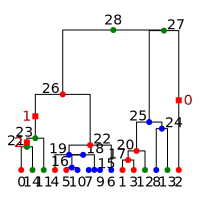

In [18]:
pop_configs = [
    msprime.PopulationConfiguration(sample_size=6),
    msprime.PopulationConfiguration(sample_size=5),
    msprime.PopulationConfiguration(sample_size=4)]

# M[j, k] define the fraction of population j that consist of migrant
# from population k in each generation
M = [
    [0, 0.5, 0.5],
    [0.5, 0, 0.5],
    [0.5, 0.5, 0]]
ts  = msprime.simulate(
    population_configurations=pop_configs, mutation_rate=2e-5,  
    migration_matrix=M, length=1e4, record_migrations=True)
tree = ts.first()
colour_map = {0:"red", 1:"blue", 2: "green"}
node_colours = {u: colour_map[tree.population(u)] for u in tree.nodes()}
SVG(tree.draw(node_colours=node_colours))

# the pattern is more like reseeding metastasis --> primary
# another pattern polyclonal seeding primary --> other site -->metastasis

In [19]:
for variant in ts.variants():
    print(
         variant.site.id, variant.site.position,
        variant.alleles, variant.genotypes, sep="\t")

0	6428.687516599894	('0', '1')	[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
1	6556.682533118874	('0', '1')	[1 0 0 0 0 0 0 0 0 0 0 1 0 0 1]
2	6760.5406837537885	('0', '1')	[1 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


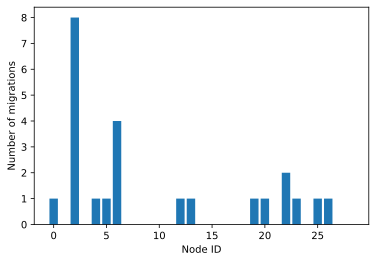

In [20]:
node_count = np.zeros(ts.num_nodes)
for migration in ts.migrations():
    node_count[migration.node] += 1
plt.bar(np.arange(ts.num_nodes), node_count)
plt.xlabel("Node ID")
plt.ylabel("Number of migrations");

In [21]:
tree_sq2 = msprime.simulate(
            sample_size=6, Ne=1000, length=1e4, recombination_rate=2e-8)

for tree in tree_sq2.trees():
    print("-" * 20)
    print("tree {}: interval = {}".format(tree.index, tree.interval))
    print(tree.draw(format="unicode"))

--------------------
tree 0: interval = Interval(left=0.0, right=5120.525049306574)
   11      
 ┏━━┻━━━┓  
 ┃     10  
 ┃    ┏━┻━┓
 ┃    8   ┃
 ┃   ┏┻━┓ ┃
 7   ┃  ┃ ┃
┏┻┓  ┃  ┃ ┃
┃ ┃  6  ┃ ┃
┃ ┃ ┏┻┓ ┃ ┃
0 1 2 4 5 3

--------------------
tree 1: interval = Interval(left=5120.525049306574, right=10000.0)
    10     
  ┏━━┻━━┓  
  9     ┃  
 ┏┻━┓   ┃  
 ┃  ┃   8  
 ┃  ┃  ┏┻━┓
 7  ┃  ┃  ┃
┏┻┓ ┃  ┃  ┃
┃ ┃ ┃  6  ┃
┃ ┃ ┃ ┏┻┓ ┃
0 1 3 2 4 5



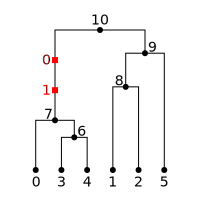

In [22]:
tree_sequence = msprime.simulate(
    sample_size=6, Ne=1000, length=50e3, mutation_rate=1e-8)
tree = tree_sequence.first()
SVG(tree.draw())

In [23]:
# the position of mutation in the tree shown
# has nothing to do with the branch_length
for site in tree.sites():
     for mutation in site.mutations:
         print("Mutation {} @ position {:.2f} over node {}".format(site.id, 
             site.position, mutation.node))

Mutation 0 @ position 34034.69 over node 7
Mutation 1 @ position 46905.68 over node 7


In [24]:
tree.branch_length(0)

272.53007776753884

In [25]:
tree.time(7) == tree.branch_length(6)+ tree.branch_length(0)

False